In [15]:
import pandas as pd
import numpy as np
from datetime import datetime as dt


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG,display
from graphviz import Source


from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/SeoulBikeData - SeoulBikeData.csv')


df_new = df.copy()

df_new.rename(columns= {'Date':'date','Rented Bike Count': 'rented_bike_count', 'Hour':'hour',
                    'Temperature(蚓)':'temperature', 'Humidity(%)':'humidity',
                    'Wind speed (m/s)': 'wind_speed', 'Visibility (10m)': 'visibility',
                    'Dew point temperature(蚓)':'dew_point_temp',
                    'Solar Radiation (MJ/m2)': 'solar_radiation', 'Rainfall(mm)': 'rainfall',
                    'Snowfall (cm)':'snowfall', 'Seasons':'seasons',
                    'Holiday':'holiday', 'Functioning Day':'func_day'},
          inplace=True)

df_new['date'] = df_new['date'].apply(lambda x: dt.strptime(x,'%d/%m/%Y'))
df_new['month'] = df_new['date'].apply(lambda x : x.month)
df_new['day_of_week'] = df_new['date'].apply(lambda x : x.isoweekday())
df_new['year'] = df_new['date'].apply(lambda x : x.year)
df_new.drop('date', axis=1, inplace = True)
df_new['snowfall'] = df_new['snowfall'].apply(lambda x: 1 if x>0 else 0)
df_new['rainfall'] = df_new['rainfall'].apply(lambda x: 1 if x>0 else 0)
df_new['visibility'] = df_new['visibility'].apply(lambda x: 0 if 0<=x<=399 else (1 if 400<=x<=999 else 2))
df_new['func_day'] = np.where(df_new['func_day'] == 'Yes',1,0)
df_new['holiday'] = np.where(df_new['holiday'] == 'Holiday',1,0)
df_new['seasons'] = df_new['seasons'].map({'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3})

df_new


import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Assuming df_new is your DataFrame
# If not, replace df_new with your actual DataFrame

# Extracting features and target variable
X = df_new.drop('rented_bike_count', axis=1)  # Features
y = df_new['rented_bike_count']  # Target variable

# Standardize the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
num_components = min(X.shape[0], X.shape[1])  # Number of components is minimum of rows and columns
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)

# Display the explained variance ratio for each principal component
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Explained Variance Ratio:
[0.20937425 0.15604197 0.10446075 0.08223972 0.07036052 0.06524249
 0.06371618 0.05790437 0.05170661 0.04924466 0.03885301 0.03501023
 0.01440094 0.00115364 0.00029067]


In [5]:
X_pca

array([[ 3.0511185 ,  1.07391663,  2.81498345, ...,  0.53553057,
         0.0446869 ,  0.01786605],
       [ 2.84161695,  1.50397304,  2.92144295, ...,  0.40849342,
         0.04533157,  0.01696405],
       [ 2.8853778 ,  1.43627847,  2.90725188, ...,  0.34313912,
         0.04475794,  0.02425054],
       ...,
       [ 0.16163823, -0.32792272,  1.51272457, ..., -0.04034804,
        -0.13836483,  0.02680575],
       [ 0.25891883, -0.52846222,  1.45352776, ..., -0.11658038,
        -0.13999239,  0.0318994 ],
       [ 0.26776672, -0.60914771,  1.42174788, ..., -0.1976344 ,
        -0.14153181,  0.04258457]])

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LinearRegression

In [29]:
k_wrapper = 6  # Number of features to select
model = LinearRegression()
rfe_selector = RFE(model, n_features_to_select=k_wrapper)
X_rfe = rfe_selector.fit_transform(X_pca, y)

# Getting the mask of selected features
selected_features_mask = rfe_selector.support_

# Since we can't get original feature names from PCA components, we can only know which components are selected
selected_components = [i for i, x in enumerate(selected_features_mask) if x]
print("Selected PCA Components Indices:", selected_components)

Selected PCA Components Indices: [1, 5, 6, 8, 12, 13]


In [30]:
df1 = df_new.iloc[:, selected_components]
y = np.sqrt(df_new[['rented_bike_count']])

X_train, X_test, y_train, y_test = train_test_split( df1, y, test_size = 0.3, random_state = 0)

In [31]:
# Defining a function to print evaluation matrix
def evaluate_model(model, y_test, y_pred):

  '''takes model, y test and y pred values to print evaluation metrics, plot the actual and predicted values,
  plot the top 20 important features, and returns a list of the model scores'''

  # Squring the y test and and pred as we have used sqrt transformation
  y_t = np.square(y_test)
  y_p = np.square(y_pred)
  y_train2 = np.square(y_train)
  y_train_pred = np.square(model.predict(X_train))

  # Calculating Evaluation Matrix
  mse = mean_squared_error(y_t,y_p)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_t,y_p)
  r2_train = r2_score(y_train2, y_train_pred)
  r2 = r2_score(y_t,y_p)
  r2_adjusted = 1-(1-r2)*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))

  # Printing Evaluation Matrix
  print("MSE :" , mse)
  print("RMSE :" ,rmse)
  print("MAE :" ,mae)
  print("Train R2 :" ,r2_train)
  print("Test R2 :" ,r2)
  print("Adjusted R2 : ", r2_adjusted)


  # plot actual and predicted values
  plt.figure(figsize=(13,4))
  plt.plot((y_p)[:100])
  plt.plot((np.array(y_t)[:100]))
  plt.legend(["Predicted","Actual"])
  plt.title('Actual and Predicted Bike Count', fontsize=15)

  model_score = [mse,rmse,mae,r2_train,r2,r2_adjusted]
  return model_score



score = pd.DataFrame(index = ['MSE', 'RMSE', 'MAE', 'Train R2', 'Test R2', 'Adjusted R2'])

MSE : 275683.6348808664
RMSE : 525.055839774082
MAE : 380.48432672081714
Train R2 : 0.31993198494105757
Test R2 : 0.32420657172226097
Adjusted R2 :  0.322659543652949
The optimum alpha value is found out to be : {'alpha': 0.0001}

Using  {'alpha': 0.0001}  the negative mean squared error is:  -65.27650648874938
MSE : 209201.86022080915
RMSE : 457.38589858106593
MAE : 322.72391157627186
Train R2 : 0.4852092829249073
Test R2 : 0.487175789807779
Adjusted R2 :  0.4860018312953206
MSE : 209238.84605236616
RMSE : 457.4263285517857
MAE : 322.72829722322564
Train R2 : 0.4850688420929298
Test R2 : 0.4870851250792889
Adjusted R2 :  0.48591095901689885
MSE : 131597.7341555874
RMSE : 362.76401992974354
MAE : 212.22081061056957
Train R2 : 0.9915931985065529
Test R2 : 0.6774096367489559
Adjusted R2 :  0.6766711620524637
MSE : 79449.86579563328
RMSE : 281.8685257272143
MAE : 170.24766811622283
Train R2 : 0.9681269398610418
Test R2 : 0.8052416234085148
Adjusted R2 :  0.8047957820275347
MSE : 83929.994

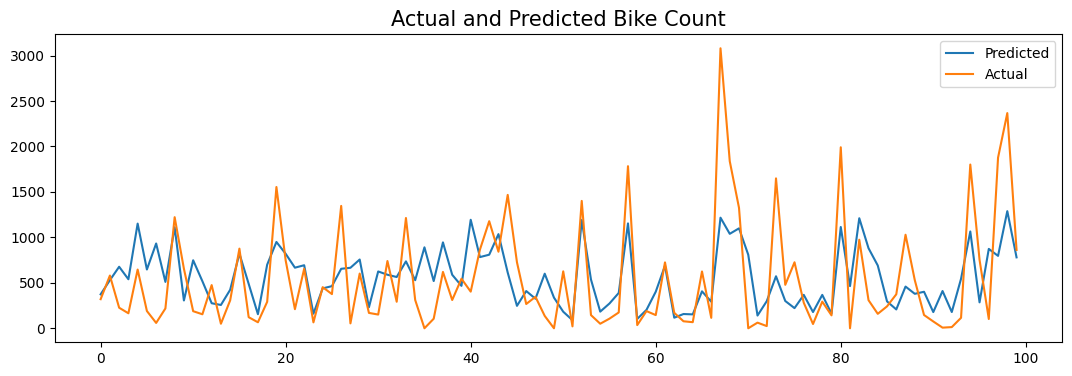

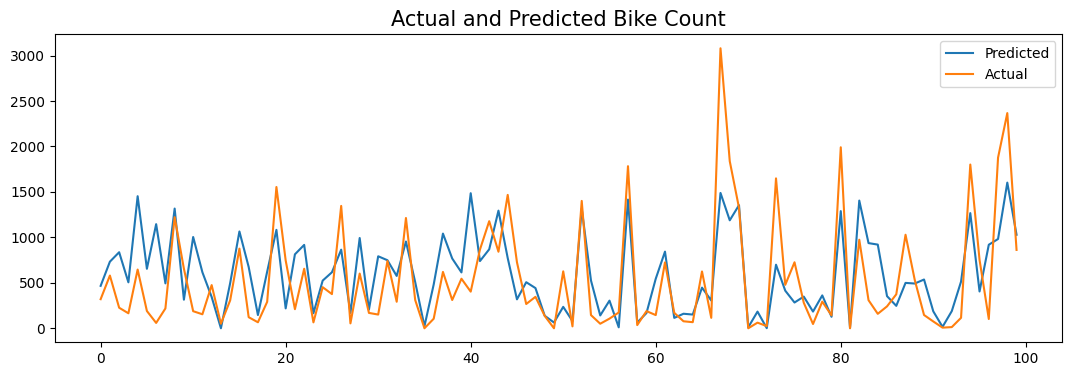

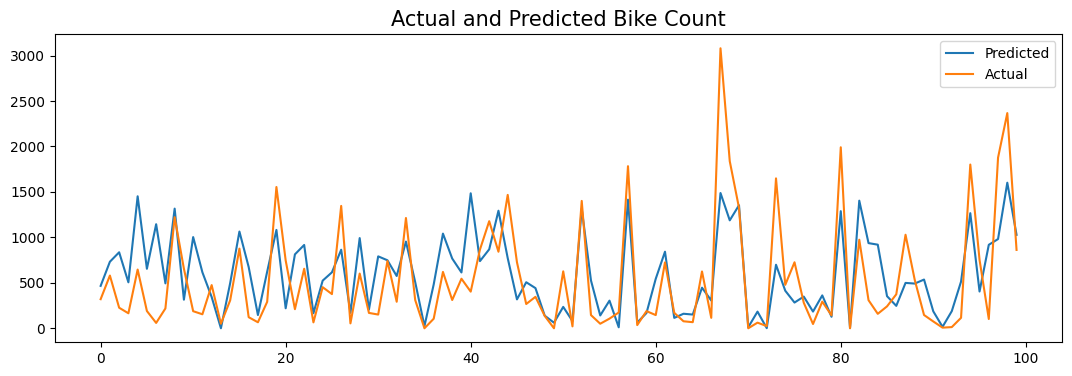

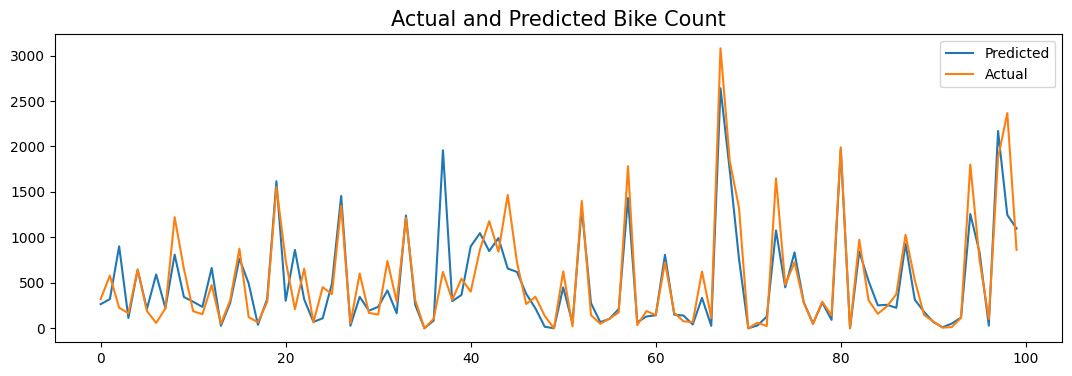

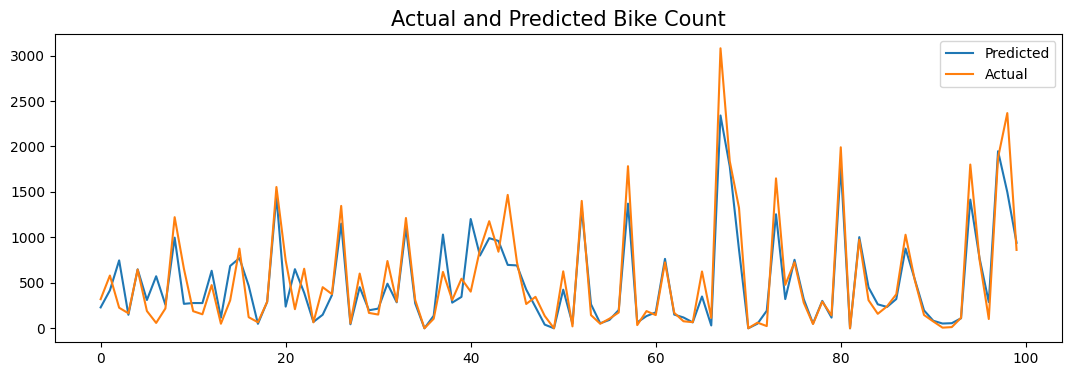

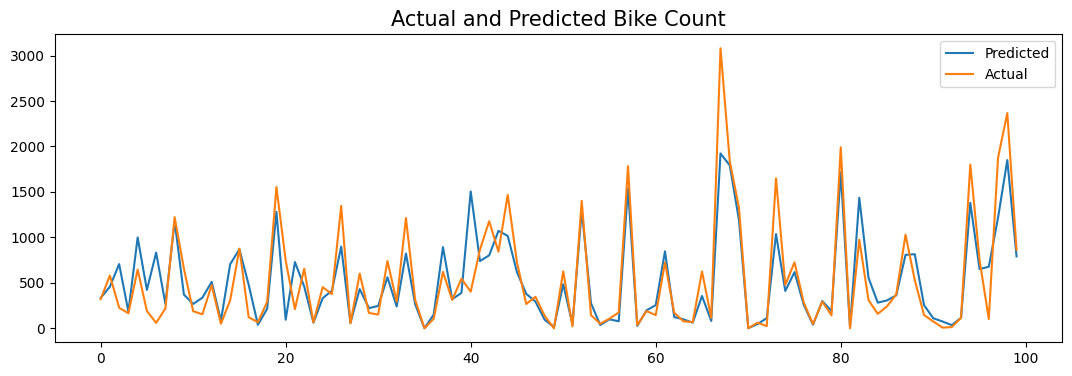

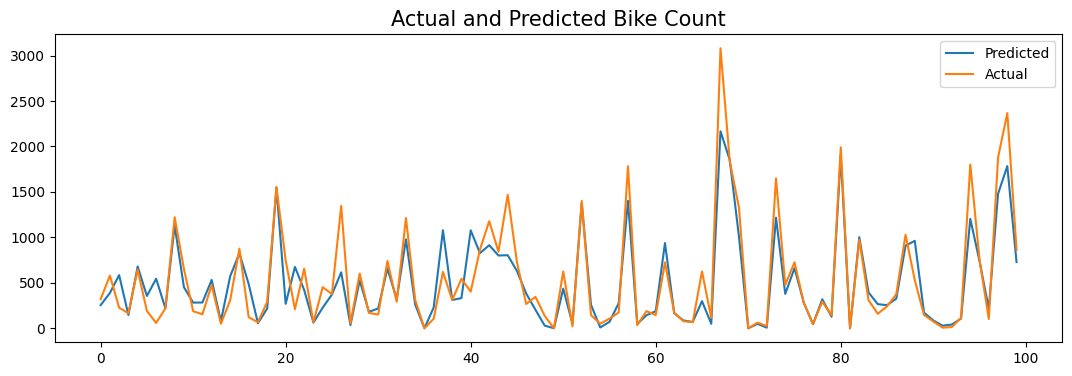

In [32]:
#Lasso regression
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso1 = lasso.predict(X_test)

lasso_score = evaluate_model(lasso, y_test,y_pred_lasso1)
score['Lasso regression'] = lasso_score

# Define the model
lasso = Lasso()

# Define the parameters to be optimized & Perform grid search
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

# Fitting model
lasso_regressor.fit(X_train,y_train)


# Getting optimum parameters
print("The optimum alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

# Import the Lasso Regression class with best alpha
lasso = Lasso(alpha = lasso_regressor.best_params_['alpha'])

# Fit the lasso regression model to your training data
lasso.fit(X_train, y_train)

# Predict the model
y_pred_lassocv = lasso.predict(X_test)

#Evaluation matrices for Lasso regression
lasso2 = evaluate_model(lasso, y_test,y_pred_lassocv)

name = 'Lasso with alpha = ' + str(lasso_regressor.best_params_['alpha'])

score[name] = lasso2

ridge = Ridge()

# Fit the ridge regression model to your training data
ridge.fit(X_train, y_train)

# Predict on the model
y_pred_ridge1 = ridge.predict(X_test)

result = evaluate_model(ridge, y_test,y_pred_ridge1)
score['Ridge'] = result

dt = DecisionTreeRegressor(random_state=1)

# Fit the Decision Tree model to your training data
dt.fit(X_train,y_train)

# Predict on the model
y_pred_dt = dt.predict(X_test)

result = evaluate_model(dt, y_test,y_pred_dt)
score['Decision tree'] = result

rf = RandomForestRegressor(random_state=0)

# Fit the Random Forest model to your training data
rf.fit(X_train,y_train)

# Predict on the model
y_pred_rf1 = rf.predict(X_test)

result = evaluate_model(rf, y_test,y_pred_rf1)
score['Random forest'] = result

gb = GradientBoostingRegressor(random_state=0)

# Fit the Gradient Boosting model to the training data
gb.fit(X_train,y_train)

# Predict on the model
y_pred_gb1 = gb.predict(X_test)


result = evaluate_model(gb, y_test,y_pred_gb1)
score['Gradient Boosting Regressor'] = result

xgb_model = xgb.XGBRegressor(random_state=0,
                             objective='reg:squarederror')

# Fit the Extreme Gradient Boosting model to the training data
xgb_model.fit(X_train,y_train)

# Predict on the model
y_pred_xgb1 = xgb_model.predict(X_test)


result = evaluate_model(xgb_model, y_test,y_pred_xgb1)
score['Extreme Gradient Boosting Regressor'] = result

In [33]:
score

,Lasso regression,Lasso with alpha = 0.0001,Ridge,Decision tree,Random forest,Gradient Boosting Regressor,Extreme Gradient Boosting Regressor
MSE,275683.634881,209201.860221,209238.846052,131597.734156,79449.865796,83929.994831,72294.359907
RMSE,525.055840,457.385899,457.426329,362.764020,281.868526,289.706739,268.876105
MAE,380.484327,322.723912,322.728297,212.220811,170.247668,184.858534,165.112562
Train R2,0.319932,0.485209,0.485069,0.991593,0.968127,0.801400,0.921697
Test R2,0.324207,0.487176,0.487085,0.677410,0.805242,0.794259,0.822782
Adjusted R2,0.322660,0.486002,0.485911,0.676671,0.804796,0.793788,0.822376


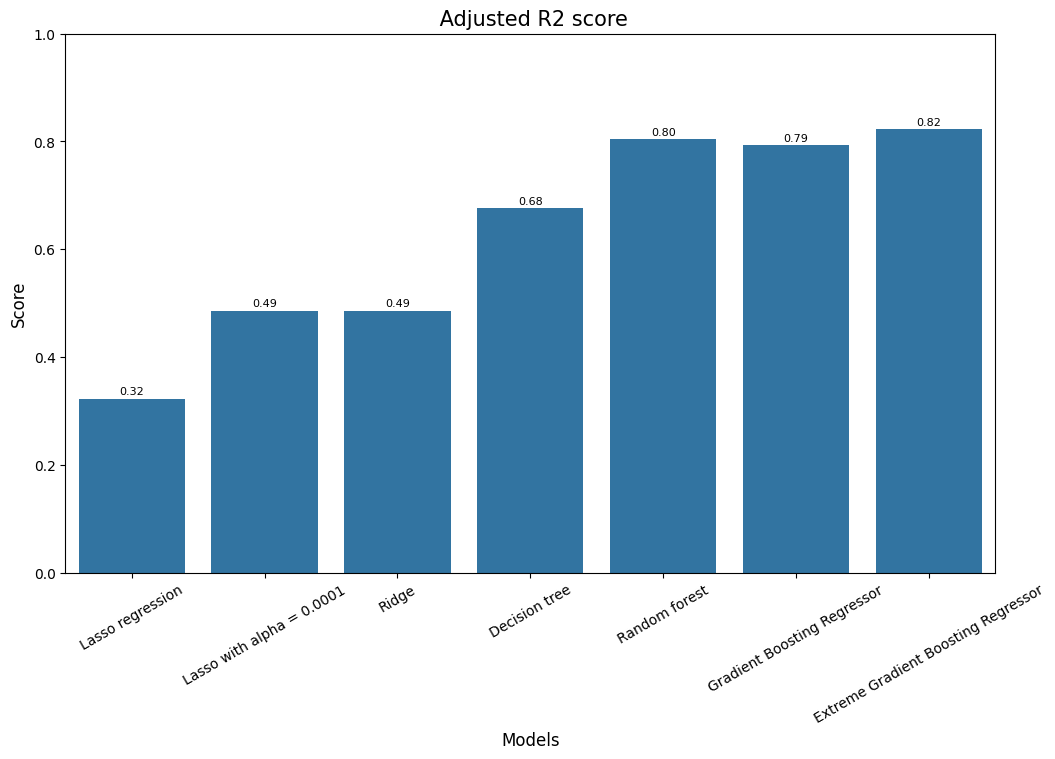

In [34]:
# Removing the overfitted models which have more than 5% gap between train and test values
score_t = score.transpose()            #taking transpose of the score dataframe to create new difference column
score_t['diff']=score_t['Train R2']-score_t['Test R2']                   #creating new column diff of train R2 and test R2 score

adj = score_t['Adjusted R2']                     #creating a new dataframe with required models and adjusted r2 score


# Visualizing a bar plot for adjusted R2 score
plt.figure(figsize=(12,7))
plots = sns.barplot(x=list(adj.index), y=adj)
for bar in plots.patches:
  plots.annotate(format(bar.get_height(),'.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 5),
                   textcoords='offset points')
plt.xticks(rotation=30)

plt.title(" Adjusted R2 score", fontsize = 15)
plt.xlabel('Models', fontsize = 12)
plt.ylabel('Score', fontsize = 12)

# Setting limit of the y axis from 0 to 30
plt.ylim(0,1)
plt.show()